In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import fitsio
import desimodel.io
import desitarget.mtl
from desitarget.targetmask import desi_mask, obsconditions
from collections import Counter
import subprocess
%matplotlib inline

In [2]:
mtl_file = "targets/dr8_mtl_dark_gray_northern_cap.fits"
mtl_data = Table.read(mtl_file)

In [3]:
print(len(mtl_data))
r = np.random.random(len(mtl_data))
rr = r<0.0001

61201562


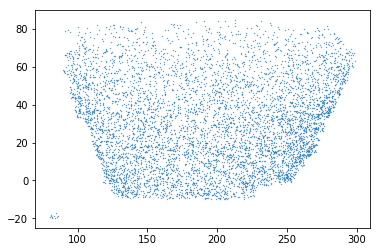

In [5]:
plt.scatter(mtl_data['RA'][rr], mtl_data['DEC'][rr], s=0.1)

# Create a smaller mtl file

In [6]:
subset_ii = (mtl_data['RA']>145) & (mtl_data['RA']<205)
subset_ii &= (mtl_data['DEC']>-5) & (mtl_data['DEC']<25)
new_mtl_file = "targets/subset_dr8_mtl_dark_gray_northern_cap.fits"
mtl_data[subset_ii].write(new_mtl_file, overwrite=True)

In [7]:
targets = Table.read(new_mtl_file)

In [8]:
sky_file = "targets/subset_dr8_sky.fits"
if not os.path.exists(skyfile):
    sky_data = Table.read("/project/projectdirs/desi/target/catalogs/dr8/0.31.0/skies/skies-dr8-0.31.0.fits")
    subset_ii = (sky_data['RA']>145) & (sky_data['RA']<205)
    subset_ii &= (sky_data['DEC']>-5) & (sky_data['DEC']<25)
    print('writing sky')
    sky_data[subset_ii].write(sky_file, overwrite=True)
    print('done writing sky')

NameError: name 'skyfile' is not defined

# Build the corresponding truth catalog

In [ ]:
#truth file
truthfile = "targets/subset_truth_dr8_mtl_dark_gray_northern_cap.fits"
if not os.path.exists(truthfile):
    import desitarget.mock.mockmaker as mb
    from desitarget.targetmask import desi_mask, bgs_mask, mws_mask

    #targetsfilename = "small_chunk_targets-dr5.0-0.16.2.fits"
    #targets = fitsio.read(targetfile, 'TARGETS', columns=columns)
    colnames = list(targets.dtype.names)
    print(colnames)
    nobj = len(targets)
    truth = mb.empty_truth_table(nobj=nobj)[0]
    print(truth.keys())

    for k in colnames:
        if k in truth.keys():
            print(k)
            truth[k][:] = targets[k][:]

    nothing = '          '
    truth['TEMPLATESUBTYPE'] = np.repeat(nothing, nobj)

    masks = ['ELG', 'LRG', 'QSO', 'MWS_ANY', 'BGS_ANY', 'STD_FAINT', 'STD_BRIGHT']
    dict_truespectype = {'BGS_ANY':'GALAXY', 'ELG':'GALAXY', 'LRG':'GALAXY', 'QSO':'QSO', 
                    'MWS_ANY':'STAR', 'STD_FAINT':'STAR', 'STD_BRIGHT':'STAR'}
    dict_truetemplatetype = {'BGS_ANY':'BGS', 'ELG':'ELG', 'LRG':'LRG', 'QSO':'QSO', 
                        'MWS_ANY':'STAR', 'STD_FAINT':'STAR', 'STD_BRIGHT':'STAR'}

    for m in masks:
        istype = (targets['DESI_TARGET'] & desi_mask.mask(m))!=0
        print(m, np.count_nonzero(istype))
        truth['TRUESPECTYPE'][istype] = np.repeat(dict_truespectype[m], np.count_nonzero(istype))
        truth['TEMPLATETYPE'][istype] = np.repeat(dict_truetemplatetype[m], np.count_nonzero(istype))
        truth['MOCKID'][istype] = targets['TARGETID'][istype]

    # Check that all targets have been assigned to a class
    iii = truth['MOCKID']==0
    assert np.count_nonzero(iii)==0
    
    print('writing truth')
    truth.write(truthfile, overwrite=True)
    print('done truth')


In [ ]:
tiles = Table(desimodel.io.load_tiles())

ii_tiles = tiles['PROGRAM'] != 'BRIGHT'
ii_tiles &= tiles['RA'] > 150 
ii_tiles &= tiles['RA'] < 200
ii_tiles &= tiles['DEC'] > 0
ii_tiles &= tiles['DEC'] < 20

tilefile = 'footprint/subset_dark123_gray.fits'
tiles[ii_tiles].write(tilefile, overwrite='True')

In [ ]:
#p = subprocess.call(["fba_run", "--targets", new_mtl_file,'--sky', sky_file,'--footprint', tilefile,'--dir',  ' fiberassign/', '--overwrite'])

In [ ]:
# fba_run --targets targets/subset_dr8_mtl_dark_gray_northern_cap.fits --sky targets/subset_dr8_sky.fits --footprint footprint/subset_dark123_gray.fits --dir fiberassign/

In [74]:
l

'fba_run --targets targets/subset_dr8_mtl_dark_gray_northern_cap.fits --sky targets/subset_dr8_sky.fits --footprint footprint/subset_dark123_gray.fits --dir  fiberassign --overwrite '